# Lab 1: Hands-On Image Generation and Diffusion Fundamentals
**Course: Diffusion Models: Theory and Applications**  
**Duration: 90 minutes**  
**Team Size: 2 students**

---

## Learning Objectives
By the end of this lab, students will be able to:
1. **Implement** a naive direct image generator and understand its limitations
2. **Design and code** different noise addition schedules for the forward diffusion process
3. **Build** a U-Net denoising network with time embeddings from scratch
4. **Train** diffusion models using the noise prediction objective
5. **Generate** new images using the reverse diffusion sampling process
6. **Compare** different generation approaches quantitatively and qualitatively
7. **Form** effective teams for the course mini-project

---

## Prerequisites
- Basic PyTorch knowledge (tensors, nn.Module, training loops)
- Understanding of convolutional neural networks
- Familiarity with image data representation

---

## Lab Setup and Environment

### Part 1: Team Formation & Setup (10 minutes)

#### Task 1.1: Find Your Lab Partner & Set Goals
- Form teams of 2 students (this will be your mini-project team)
- Exchange contact information and GitHub usernames
- **Today's Mission**: Build 4 different image generation systems from scratch
- **Success Criteria**: Generate recognizable MNIST digits by the end of lab

#### Task 1.2: Environment Setup

Using device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.85MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.10MB/s]


Training samples: 60000
Test samples: 10000


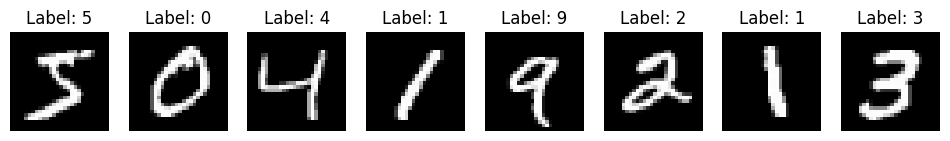

In [1]:
# Required imports - run this first!
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Visualization helper function (provided)
def show_mnist_samples(dataset, num_samples=8):
    """Display a grid of MNIST samples"""
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 2))
    for i in range(num_samples):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

def show_image_grid(images, title="Generated Images", nrow=4):
    """Helper function to display a grid of images"""
    images = images.cpu()
    num_images = min(16, images.shape[0])
    ncol = min(nrow, num_images)
    nrow_actual = (num_images + ncol - 1) // ncol

    fig, axes = plt.subplots(nrow_actual, ncol, figsize=(ncol*2, nrow_actual*2))
    if nrow_actual == 1:
        axes = [axes] if ncol == 1 else axes
    elif ncol == 1:
        axes = [[ax] for ax in axes]

    for i in range(num_images):
        row, col = i // ncol, i % ncol
        if nrow_actual == 1:
            ax = axes[col] if ncol > 1 else axes
        else:
            ax = axes[row][col] if ncol > 1 else axes[row]
        ax.imshow(images[i, 0], cmap='gray', vmin=-1, vmax=1)
        ax.axis('off')

    # Hide unused subplots
    for i in range(num_images, nrow_actual * ncol):
        row, col = i // ncol, i % ncol
        if nrow_actual == 1:
            ax = axes[col] if ncol > 1 else axes
        else:
            ax = axes[row][col] if ncol > 1 else axes[row]
        ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_mnist_samples(train_dataset)

---

## Part 2: Implement a Naive Direct Generator (25 minutes)

### Task 2.1: Build Your First Generator

**Your Mission**: Create a neural network that maps random noise directly to MNIST digits.

In [ ]:
class DirectGenerator(nn.Module):
    def __init__(self, latent_dim=64, image_size=28):
        super().__init__()
        self.image_size = image_size
        self.latent_dim = latent_dim
        self.network = nn.Sequential(nn.Linear)

        # TODO: Implement your generator architecture
        # Required components:
        # 1. Input layer: Linear(latent_dim, 256)
        # 2. Activation: ReLU() or LeakyReLU()
        # 3. Hidden layer: Linear(256, 512)
        # 4. Another activation function
        # 5. Output layer: Linear(512, image_size * image_size)
        # 6. Final activation: Tanh() (since MNIST is normalized to [-1,1])
        #
        # Architecture flow: latent_dim → 256 → 512 → 784 → reshape to (1,28,28)

        # TODO: Create self.network as a nn.Sequential with the layers above
        self.network = None

    def forward(self, z):
        # TODO: Implement the forward pass
        # Steps:
        # 1. Pass z through your network
        # 2. Reshape to image format: output.view(-1, 1, self.image_size, self.image_size)
        #
        # Input: z of shape (batch_size, latent_dim)
        # Output: images of shape (batch_size, 1, image_size, image_size)
        pass

# Test your implementation
generator = DirectGenerator().to(device)
test_z = torch.randn(4, 64).to(device)

try:
    test_output = generator(test_z)
    print(f"Input shape: {test_z.shape}")
    print(f"Output shape: {test_output.shape}")
    print(f"Output range: [{test_output.min():.3f}, {test_output.max():.3f}]")

    # This should pass:
    assert test_output.shape == (4, 1, 28, 28), f"Expected (4,1,28,28), got {test_output.shape}"
    print("✓ Generator architecture test passed!")
except Exception as e:
    print(f"Generator test failed: {e}")
    print("Make sure to implement the network architecture and forward method!")

### Task 2.2: Implement Training Loop

**Your Mission**: Train your generator using statistical matching.

In [ ]:
def train_direct_generator(generator, dataloader, epochs=5, device='cpu'):
    """
    Train generator using statistical matching approach.

    The Challenge: How do you train a generator without paired data?

    Solution - Statistical Matching:
    Train the generator so its outputs have similar statistics to real MNIST images.
    """

    optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
    generator.train()

    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0

        for batch_idx, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # TODO: Implement your training step
            # Steps:
            # 1. Generate random latent codes: z = torch.randn(batch_size, generator.latent_dim).to(device)
            # 2. Generate fake images: fake_images = generator(z)
            # 3. Compute statistics for real images: real_mean, real_std
            # 4. Compute statistics for fake images: fake_mean, fake_std
            # 5. Compute loss as L1 distance between statistics
            # 6. Backpropagate: loss.backward(), optimizer.step()

            optimizer.zero_grad()

            # TODO: Your implementation here
            pass

            if batch_idx % 100 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.6f}')
                print(f'  Real mean: {real_mean.item():.4f}, std: {real_std.item():.4f}')
                print(f'  Fake mean: {fake_mean.item():.4f}, std: {fake_std.item():.4f}')

        avg_loss = total_loss / num_batches
        print(f'Epoch {epoch} completed. Average loss: {avg_loss:.6f}')

        # Generate and show samples every epoch
        with torch.no_grad():
            sample_z = torch.randn(16, generator.latent_dim).to(device)
            samples = generator(sample_z)
            show_image_grid(samples, title=f'Direct Generator - Epoch {epoch}')

    return generator

# Train your generator (uncomment after implementing)
# print("Training Direct Generator...")
# trained_generator = train_direct_generator(generator, train_loader, epochs=3, device=device)

### Task 2.3: Evaluate Your Direct Generator

In [ ]:
def evaluate_generator(generator, device='cpu', num_samples=100):
    """
    Comprehensive evaluation of generator quality and diversity
    """
    generator.eval()

    with torch.no_grad():
        # Generate samples for evaluation
        z = torch.randn(num_samples, generator.latent_dim).to(device)
        samples = generator(z)
        samples = samples.cpu()

        # 1. Visual Quality Assessment
        print("=== Visual Quality Assessment ===")
        show_image_grid(samples[:16], title="Direct Generator Samples")

        # 2. Statistical Analysis
        print("\n=== Statistical Analysis ===")
        sample_mean = torch.mean(samples).item()
        sample_std = torch.std(samples).item()

        # Compare to real MNIST statistics
        real_images = next(iter(test_loader))[0][:num_samples]
        real_mean = torch.mean(real_images).item()
        real_std = torch.std(real_images).item()

        print(f"Generated - Mean: {sample_mean:.4f}, Std: {sample_std:.4f}")
        print(f"Real MNIST - Mean: {real_mean:.4f}, Std: {real_std:.4f}")
        print(f"Mean difference: {abs(sample_mean - real_mean):.4f}")
        print(f"Std difference: {abs(sample_std - real_std):.4f}")

        # 3. Diversity Measurement
        print("\n=== Diversity Measurement ===")
        # Flatten images and compute pairwise distances
        flattened = samples.view(num_samples, -1)

        # Compute diversity as average pairwise distance
        diversity_scores = []
        for i in range(min(50, num_samples)):  # Sample subset for efficiency
            for j in range(i+1, min(50, num_samples)):
                dist = torch.norm(flattened[i] - flattened[j]).item()
                diversity_scores.append(dist)

        avg_diversity = np.mean(diversity_scores)
        print(f"Average pairwise distance: {avg_diversity:.4f}")

        # 4. Pixel Value Distribution Comparison
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.hist(samples.numpy().flatten(), bins=50, alpha=0.7, label='Generated', density=True)
        plt.hist(real_images.numpy().flatten(), bins=50, alpha=0.7, label='Real', density=True)
        plt.title('Pixel Value Distribution')
        plt.xlabel('Pixel Value')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        # Show a few samples vs real images for comparison
        for i in range(4):
            plt.subplot(2, 4, i+1)
            plt.imshow(samples[i, 0], cmap='gray')
            plt.title('Generated')
            plt.axis('off')

            plt.subplot(2, 4, i+5)
            plt.imshow(real_images[i, 0], cmap='gray')
            plt.title('Real')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        return {
            'mean_diff': abs(sample_mean - real_mean),
            'std_diff': abs(sample_std - real_std),
            'diversity': avg_diversity
        }

# Evaluate your generator (uncomment after training)
# print("Evaluating Direct Generator...")
# direct_gen_results = evaluate_generator(trained_generator, device)

**Discussion Questions:**
1. What do the generated images look like? Are they recognizable digits?
2. How do the statistics compare to real MNIST?
3. What are the main limitations you observe?

---

## Part 3: Implement Progressive Noise Addition (20 minutes)

### Task 3.1: Build Your Noise Scheduler

**Your Mission**: Implement the forward diffusion process with different noise schedules.

In [ ]:
class NoiseScheduler:
    def __init__(self, num_timesteps=1000, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device

    def get_beta_schedule(self, schedule_type="linear"):
        """
        TODO: Implement different noise schedules

        Beta schedules control how much noise is added at each timestep.

        Linear Schedule (implement first):
        - Start: beta_start = 1e-4 (very little noise)
        - End: beta_end = 0.02 (substantial noise, but not overwhelming)
        - Use torch.linspace to create smooth progression

        Cosine Schedule (advanced):
        - From "Improved Denoising Diffusion Probabilistic Models" paper
        - Creates smoother noise addition schedule

        Exponential Schedule:
        - Exponential increase in noise
        - Useful for faster noise addition in early steps
        """

        if schedule_type == "linear":
            # TODO: Implement linear schedule
            # Hint: Use torch.linspace(beta_start, beta_end, self.num_timesteps)
            pass

        elif schedule_type == "cosine":
            # TODO: Implement cosine schedule (advanced - optional)
            # Hint: Research the DDPM improved paper for exact formula
            pass

        elif schedule_type == "exponential":
            # TODO: Implement exponential schedule (advanced - optional)
            # Hint: Use torch.exp with log-space interpolation
            pass

        else:
            raise ValueError(f"Unknown schedule type: {schedule_type}")

    def precompute_coefficients(self, schedule_type="linear"):
        """
        TODO: Precompute coefficients for efficient noise addition and removal

        Key quantities to compute:
        - betas: noise schedule
        - alphas: 1 - betas
        - alpha_cumprod: cumulative product of alphas
        - sqrt_alpha_cumprod: square root for reparameterization
        - sqrt_one_minus_alpha_cumprod: for noise coefficient

        Steps:
        1. Get betas from schedule
        2. Compute alphas = 1.0 - betas
        3. Compute alpha_cumprod = torch.cumprod(alphas, dim=0)
        4. Compute square root coefficients for forward process
        """

        self.betas = self.get_beta_schedule(schedule_type)

        # TODO: Compute the derived quantities
        # self.alphas = 1.0 - self.betas
        # self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        # self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        # self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - self.alpha_cumprod)

    def add_noise(self, x0, timesteps, noise=None):
        """
        TODO: Implement noise addition for given timesteps

        This implements the forward diffusion process:
        q(x_t | x_0) = N(sqrt(alpha_cumprod_t) * x_0, (1 - alpha_cumprod_t) * I)

        Reparameterization: x_t = sqrt(alpha_cumprod_t) * x_0 + sqrt(1 - alpha_cumprod_t) * noise

        Implementation steps:
        1. Generate noise if not provided: noise = torch.randn_like(x0)
        2. Extract coefficients for given timesteps
        3. Reshape coefficients for broadcasting
        4. Apply the reparameterization formula
        5. Return noisy images and the noise that was added
        """

        if noise is None:
            noise = torch.randn_like(x0)

        # TODO: Extract coefficients for the given timesteps
        # sqrt_alpha_cumprod_t = self.sqrt_alpha_cumprod[timesteps]
        # sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alpha_cumprod[timesteps]

        # TODO: Reshape for broadcasting (batch_size,) -> (batch_size, 1, 1, 1)
        # sqrt_alpha_cumprod_t = sqrt_alpha_cumprod_t.view(-1, 1, 1, 1)
        # sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alpha_cumprod_t.view(-1, 1, 1, 1)

        # TODO: Apply forward diffusion formula
        # noisy_x = sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise

        # return noisy_x, noise
        pass

# Visualization function (provided)
def visualize_forward_process(image, scheduler, timesteps_to_show, title="Forward Diffusion Process"):
    """
    Visualize how a clean image gradually becomes pure noise
    """
    fig, axes = plt.subplots(1, len(timesteps_to_show), figsize=(15, 3))
    if len(timesteps_to_show) == 1:
        axes = [axes]

    for i, t in enumerate(timesteps_to_show):
        # Add noise for this timestep
        t_tensor = torch.tensor([t]).to(image.device)
        noisy_img, _ = scheduler.add_noise(image, t_tensor)

        # Display the noisy image
        img_to_show = noisy_img[0, 0].cpu()  # Remove batch and channel dimensions
        axes[i].imshow(img_to_show, cmap='gray', vmin=-1, vmax=1)
        axes[i].set_title(f'Step {t}')
        axes[i].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def compare_noise_schedules(image, scheduler, timesteps_to_show, schedules=["linear"]):
    """
    Compare different noise schedules side by side
    """
    fig, axes = plt.subplots(len(schedules), len(timesteps_to_show), figsize=(15, 3*len(schedules)))

    if len(schedules) == 1:
        axes = axes.reshape(1, -1)

    for i, schedule_type in enumerate(schedules):
        try:
            scheduler.precompute_coefficients(schedule_type)

            for j, t in enumerate(timesteps_to_show):
                t_tensor = torch.tensor([t]).to(image.device)
                noisy_img, _ = scheduler.add_noise(image, t_tensor)

                img_to_show = noisy_img[0, 0].cpu()
                axes[i, j].imshow(img_to_show, cmap='gray', vmin=-1, vmax=1)
                if i == 0:
                    axes[i, j].set_title(f'Step {t}')
                if j == 0:
                    axes[i, j].set_ylabel(schedule_type.capitalize())
                axes[i, j].axis('off')
        except:
            # If schedule not implemented, show placeholder
            for j, t in enumerate(timesteps_to_show):
                axes[i, j].text(0.5, 0.5, f'{schedule_type}\nNot Implemented',
                               ha='center', va='center', transform=axes[i, j].transAxes)
                axes[i, j].axis('off')

    plt.suptitle('Comparison of Noise Schedules')
    plt.tight_layout()
    plt.show()

# Test your scheduler implementation
scheduler = NoiseScheduler(num_timesteps=1000, device=device)

try:
    scheduler.precompute_coefficients("linear")

    # Test with a sample image
    test_image = next(iter(test_loader))[0][:1].to(device)  # Get one image
    test_timesteps = torch.tensor([0, 250, 500, 750, 999]).to(device)

    print("Testing noise addition...")
    for t in test_timesteps:
        noisy_img, noise = scheduler.add_noise(test_image, torch.tensor([t]).to(device))
        print(f"Timestep {t}: Image range [{noisy_img.min():.3f}, {noisy_img.max():.3f}]")

    print("✓ Noise scheduler test passed!")

    # Visualize the forward process
    timesteps_to_show = [0, 100, 300, 500, 700, 999]
    print("Visualizing forward diffusion process...")
    visualize_forward_process(test_image, scheduler, timesteps_to_show)

    # Compare different schedules (will show "Not Implemented" for unimplemented ones)
    print("Comparing different noise schedules...")
    compare_noise_schedules(test_image, scheduler, timesteps_to_show,
                           schedules=["linear", "cosine", "exponential"])

    # Reset to linear schedule for the rest of the lab
    scheduler.precompute_coefficients("linear")

except Exception as e:
    print(f"Noise scheduler test failed: {e}")
    print("Make sure to implement get_beta_schedule and precompute_coefficients!")

---

## Part 4: Implement Simple Denoising Network (25 minutes)

### Task 4.1: Build a U-Net Denoiser

**Your Mission**: Create a U-Net architecture that can predict noise given a noisy image and timestep.

In [ ]:
class SimpleDenoiser(nn.Module):
    def __init__(self, in_channels=1, time_embed_dim=32):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        # TODO: Implement U-Net architecture with time embedding

        # Time embedding: converts timestep to feature vector
        # This is provided as it's complex and not the main learning objective
        self.time_embedding = nn.Sequential(
            nn.Embedding(1000, time_embed_dim),
            nn.ReLU(),
            nn.Linear(time_embed_dim, time_embed_dim)
        )

        # TODO: Implement Encoder (downsampling path)
        # Architecture suggestion:
        # encoder1: Conv2d(in_channels + time_embed_dim, 64) -> ReLU -> Conv2d(64, 64) -> ReLU
        # encoder2: MaxPool2d(2) -> Conv2d(64, 128) -> ReLU -> Conv2d(128, 128) -> ReLU
        # encoder3: MaxPool2d(2) -> Conv2d(128, 256) -> ReLU -> Conv2d(256, 256) -> ReLU

        # TODO: Implement Bottleneck
        # bottleneck: MaxPool2d(2) -> Conv2d(256, 512) -> ReLU -> Conv2d(512, 512) -> ReLU

        # TODO: Implement Decoder (upsampling path)
        # decoder3: ConvTranspose2d(512, 256) -> ReLU
        # decoder3_conv: Conv2d(256 + 256, 256) -> ReLU -> Conv2d(256, 256) -> ReLU
        # decoder2: ConvTranspose2d(256, 128) -> ReLU
        # decoder2_conv: Conv2d(128 + 128, 128) -> ReLU -> Conv2d(128, 128) -> ReLU
        # decoder1: ConvTranspose2d(128, 64) -> ReLU
        # decoder1_conv: Conv2d(64 + 64, 64) -> ReLU -> Conv2d(64, 64) -> ReLU

        # TODO: Implement Final output layer
        # final: Conv2d(64, in_channels, 1)  # 1x1 conv to get back to input channels

    def forward(self, x, timesteps):
        """
        TODO: Implement forward pass with skip connections

        Args:
            x: noisy images (batch_size, channels, height, width)
            timesteps: timestep for each image (batch_size,)

        Returns:
            predicted_noise: same shape as x

        Steps:
        1. Embed timesteps and expand to image dimensions
        2. Concatenate time embedding with input
        3. Pass through encoder (save features for skip connections)
        4. Pass through bottleneck
        5. Pass through decoder with skip connections
        6. Return predicted noise
        """

        # Get batch size and spatial dimensions
        batch_size, channels, height, width = x.shape

        # Embed timesteps (provided - complex time embedding logic)
        time_emb = self.time_embedding(timesteps)  # (batch_size, time_embed_dim)
        time_emb = time_emb.view(batch_size, self.time_embed_dim, 1, 1)  # Add spatial dims
        time_emb = time_emb.expand(-1, -1, height, width)  # Broadcast to image size

        # Concatenate time embedding with input
        x_with_time = torch.cat([x, time_emb], dim=1)

        # TODO: Implement encoder path (save features for skip connections)
        # enc1 = self.encoder1(x_with_time)
        # enc2 = self.encoder2(enc1)
        # enc3 = self.encoder3(enc2)

        # TODO: Implement bottleneck
        # bottleneck = self.bottleneck(enc3)

        # TODO: Implement decoder path (with skip connections)
        # Handle potential size mismatches with F.interpolate if needed
        # dec3 = self.decoder3(bottleneck)
        # dec3 = torch.cat([dec3, enc3], dim=1)  # Skip connection
        # dec3 = self.decoder3_conv(dec3)

        # TODO: Continue with decoder2 and decoder1

        # TODO: Final output
        # predicted_noise = self.final(dec1)

        # return predicted_noise
        pass

# Test your denoiser implementation
try:
    denoiser = SimpleDenoiser().to(device)
    test_noisy = torch.randn(4, 1, 28, 28).to(device)
    test_timesteps = torch.randint(0, 1000, (4,)).to(device)

    test_output = denoiser(test_noisy, test_timesteps)
    print(f"Denoiser input shape: {test_noisy.shape}")
    print(f"Denoiser output shape: {test_output.shape}")
    print(f"Timesteps: {test_timesteps}")

    # Verify the denoiser works correctly
    assert test_output.shape == test_noisy.shape, f"Expected {test_noisy.shape}, got {test_output.shape}"

    # Test that different timesteps produce different outputs
    same_image = torch.randn(1, 1, 28, 28).to(device)
    t1 = torch.tensor([100]).to(device)
    t2 = torch.tensor([900]).to(device)

    out1 = denoiser(same_image, t1)
    out2 = denoiser(same_image, t2)

    different_outputs = not torch.allclose(out1, out2, atol=1e-5)
    print(f"Different timesteps produce different outputs: {different_outputs}")
    assert different_outputs, "Denoiser should produce different outputs for different timesteps!"

    print("✓ Denoiser architecture test passed!")

except Exception as e:
    print(f"Denoiser test failed: {e}")
    print("Make sure to implement the U-Net architecture and forward method!")

### Task 4.2: Train the Denoising Model

In [ ]:
def train_denoiser(denoiser, scheduler, dataloader, epochs=3, device='cpu'):
    """
    TODO: Implement training for the denoising model

    Training process:
    1. Take clean images from dataloader
    2. Sample random timesteps for each image
    3. Add noise using the scheduler
    4. Train denoiser to predict the added noise
    5. Use MSE loss between predicted and actual noise
    """

    optimizer = torch.optim.Adam(denoiser.parameters(), lr=0.001)
    denoiser.train()

    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0

        for batch_idx, (clean_images, _) in enumerate(dataloader):
            clean_images = clean_images.to(device)
            batch_size = clean_images.size(0)

            # TODO: Implement training step
            # Steps:
            # 1. Sample random timesteps: t = torch.randint(0, scheduler.num_timesteps, (batch_size,)).to(device)
            # 2. Add noise: noisy_images, noise = scheduler.add_noise(clean_images, t)
            # 3. Predict noise: predicted_noise = denoiser(noisy_images, t)
            # 4. Compute MSE loss: loss = F.mse_loss(predicted_noise, noise)
            # 5. Backpropagate: loss.backward(), optimizer.step()

            optimizer.zero_grad()

            # TODO: Your implementation here
            pass

            if batch_idx % 100 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.6f}')

        avg_loss = total_loss / num_batches
        print(f'Epoch {epoch} completed. Average loss: {avg_loss:.6f}')

        # Test denoising on a sample image
        with torch.no_grad():
            test_clean = clean_images[:4]
            test_t = torch.tensor([250, 500, 750, 999]).to(device)
            test_noisy, test_noise = scheduler.add_noise(test_clean, test_t)
            predicted_noise = denoiser(test_noisy, test_t)

            # Show results
            visualize_denoising_results(test_clean, test_noisy, test_noise, predicted_noise, test_t, epoch)

    return denoiser

def visualize_denoising_results(clean, noisy, true_noise, predicted_noise, timesteps, epoch):
    """Visualize denoising results during training"""
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))

    for i in range(4):
        # Original clean image
        axes[0, i].imshow(clean[i, 0].cpu(), cmap='gray', vmin=-1, vmax=1)
        axes[0, i].set_title(f'Clean Image')
        axes[0, i].axis('off')

        # Noisy image
        axes[1, i].imshow(noisy[i, 0].cpu(), cmap='gray', vmin=-1, vmax=1)
        axes[1, i].set_title(f'Noisy (t={timesteps[i]})')
        axes[1, i].axis('off')

        # True noise
        axes[2, i].imshow(true_noise[i, 0].cpu(), cmap='gray', vmin=-1, vmax=1)
        axes[2, i].set_title('True Noise')
        axes[2, i].axis('off')

        # Predicted noise
        axes[3, i].imshow(predicted_noise[i, 0].cpu(), cmap='gray', vmin=-1, vmax=1)
        axes[3, i].set_title('Predicted Noise')
        axes[3, i].axis('off')

    plt.suptitle(f'Denoising Results - Epoch {epoch}')
    plt.tight_layout()
    plt.show()

# Train your denoiser (uncomment after implementing)
# print("Training Denoiser...")
# if 'scheduler' in locals() and hasattr(scheduler, 'betas'):
#     trained_denoiser = train_denoiser(denoiser, scheduler, train_loader, epochs=3, device=device)
# else:
#     print("Please implement and test the noise scheduler first!")

### Task 4.3: Implement Reverse Sampling Process

In [ ]:
def reverse_sampling(denoiser, scheduler, num_samples=16, device='cpu'):
    """
    TODO: Implement the reverse sampling process to generate images

    This is the magic of diffusion models - start with pure noise and gradually denoise!

    Process:
    1. Start with pure noise: x_T ~ N(0, I)
    2. For t from T-1 down to 0:
       a. Predict noise: predicted_noise = denoiser(x_t, t)
       b. Remove predicted noise to get x_{t-1}
       c. Add small amount of random noise (except at t=0)
    3. Return final denoised images

    Simplified reverse formula:
    x_{t-1} = (x_t - sqrt(1-alpha_cumprod_t) * predicted_noise) / sqrt(alpha_cumprod_t)
    """

    denoiser.eval()

    with torch.no_grad():
        # TODO: Step 1 - Start with pure noise
        # x = torch.randn(num_samples, 1, 28, 28).to(device)

        # TODO: Step 2 - Reverse process loop
        # for t in reversed(range(scheduler.num_timesteps)):
        #     # Create timestep tensor for all samples
        #     t_tensor = torch.full((num_samples,), t, dtype=torch.long).to(device)
        #
        #     # Predict noise
        #     predicted_noise = denoiser(x, t_tensor)
        #
        #     # Remove noise (simplified formula)
        #     alpha_cumprod_t = scheduler.alpha_cumprod[t]
        #     sqrt_alpha_cumprod_t = torch.sqrt(alpha_cumprod_t)
        #     sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - alpha_cumprod_t)
        #
        #     x = (x - sqrt_one_minus_alpha_cumprod_t * predicted_noise) / sqrt_alpha_cumprod_t
        #
        #     # Add small random noise (except for final step)
        #     if t > 0:
        #         noise = torch.randn_like(x) * 0.1  # Small noise injection
        #         x = x + noise
        #
        #     # Show progress every 200 steps
        #     if t % 200 == 0:
        #         print(f"Reverse sampling step {t}")
        #         if t % 400 == 0:  # Show images every 400 steps
        #             show_image_grid(x[:16], f"Reverse Sampling - Step {t}")

        # TODO: Return final generated images
        # return x
        pass

def compare_all_generators():
    """
    Compare all implemented generation approaches
    """
    print("=== Comparing All Generation Approaches ===\n")

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))

    # 1. Direct Generator
    if 'trained_generator' in locals():
        with torch.no_grad():
            z = torch.randn(4, trained_generator.latent_dim).to(device)
            direct_samples = trained_generator(z)

        for i in range(4):
            axes[0, i].imshow(direct_samples[i, 0].cpu(), cmap='gray', vmin=-1, vmax=1)
            axes[0, i].set_title('Direct Generator')
            axes[0, i].axis('off')
    else:
        for i in range(4):
            axes[0, i].text(0.5, 0.5, 'Direct Generator\nNot Trained',
                           ha='center', va='center', transform=axes[0, i].transAxes)
            axes[0, i].axis('off')

    # 2. Real MNIST (for reference)
    real_samples = next(iter(test_loader))[0][:4]
    for i in range(4):
        axes[1, i].imshow(real_samples[i, 0], cmap='gray', vmin=-1, vmax=1)
        axes[1, i].set_title('Real MNIST')
        axes[1, i].axis('off')

    # 3. Diffusion Generator (if trained)
    if 'trained_denoiser' in locals() and 'scheduler' in locals():
        try:
            diffusion_samples = reverse_sampling(trained_denoiser, scheduler, num_samples=4, device=device)
            for i in range(4):
                axes[2, i].imshow(diffusion_samples[i, 0].cpu(), cmap='gray', vmin=-1, vmax=1)
                axes[2, i].set_title('Diffusion Model')
                axes[2, i].axis('off')
        except:
            for i in range(4):
                axes[2, i].text(0.5, 0.5, 'Diffusion Model\nSampling Failed',
                               ha='center', va='center', transform=axes[2, i].transAxes)
                axes[2, i].axis('off')
    else:
        for i in range(4):
            axes[2, i].text(0.5, 0.5, 'Diffusion Model\nNot Trained',
                           ha='center', va='center', transform=axes[2, i].transAxes)
            axes[2, i].axis('off')

    # 4. Noise Progression (Forward Process)
    test_img = real_samples[:1]
    timesteps = [250, 500, 750, 999]
    if 'scheduler' in locals() and hasattr(scheduler, 'betas'):
        for i, t in enumerate(timesteps):
            noisy_img, _ = scheduler.add_noise(test_img, torch.tensor([t]).to(device))
            axes[3, i].imshow(noisy_img[0, 0].cpu(), cmap='gray', vmin=-1, vmax=1)
            axes[3, i].set_title(f'Noise Process t={t}')
            axes[3, i].axis('off')
    else:
        for i in range(4):
            axes[3, i].text(0.5, 0.5, 'Noise Process\nNot Implemented',
                           ha='center', va='center', transform=axes[3, i].transAxes)
            axes[3, i].axis('off')

    plt.tight_layout()
    plt.show()

# Test reverse sampling (uncomment after implementing denoiser)
# print("Testing reverse sampling...")
# if 'trained_denoiser' in locals() and 'scheduler' in locals():
#     generated_images = reverse_sampling(trained_denoiser, scheduler, num_samples=16, device=device)
#     show_image_grid(generated_images, "Diffusion Model Generated Images")
# else:
#     print("Please train the denoiser first!")

# Compare all approaches
compare_all_generators()

---

## Part 5: Training Integration and Comparison (10 minutes)

### Task 5.1: Complete Training Pipeline

In [ ]:
def full_training_pipeline():
    """
    Complete training pipeline for diffusion model
    """
    print("=== Full Diffusion Model Training Pipeline ===\n")

    # Step 1: Initialize components
    print("1. Initializing components...")
    scheduler = NoiseScheduler(num_timesteps=1000, device=device)

    try:
        scheduler.precompute_coefficients("linear")
        print("✓ Noise scheduler initialized")
    except:
        print("❌ Noise scheduler implementation incomplete")
        return

    try:
        denoiser = SimpleDenoiser().to(device)
        # Test denoiser
        test_x = torch.randn(2, 1, 28, 28).to(device)
        test_t = torch.randint(0, 1000, (2,)).to(device)
        test_out = denoiser(test_x, test_t)
        assert test_out.shape == test_x.shape
        print("✓ Denoiser initialized")
    except Exception as e:
        print(f"❌ Denoiser implementation incomplete: {e}")
        return

    # Step 2: Train denoiser
    print("\n2. Training denoiser...")
    try:
        trained_denoiser = train_denoiser(denoiser, scheduler, train_loader, epochs=2, device=device)
        print("✓ Denoiser training completed")
    except Exception as e:
        print(f"❌ Denoiser training failed: {e}")
        return

    # Step 3: Generate samples
    print("\n3. Generating samples...")
    try:
        generated_samples = reverse_sampling(trained_denoiser, scheduler, num_samples=16, device=device)
        show_image_grid(generated_samples, "Final Generated Images")
        print("✓ Sample generation completed")
    except Exception as e:
        print(f"❌ Sample generation failed: {e}")
        return

    print("\n🎉 Full pipeline completed successfully!")
    return trained_denoiser, scheduler

# Run full pipeline (uncomment after implementing all components)
# trained_model, trained_scheduler = full_training_pipeline()

### Task 5.2: Performance Analysis

In [ ]:
def analyze_model_performance():
    """
    Analyze and compare different generation approaches
    """
    print("=== Model Performance Analysis ===\n")

    results = {}

    # 1. Direct Generator Analysis
    if 'trained_generator' in locals():
        print("Analyzing Direct Generator...")
        direct_results = evaluate_generator(trained_generator, device, num_samples=100)
        results['direct'] = direct_results

        print(f"Direct Generator Results:")
        print(f"  Mean difference from real: {direct_results['mean_diff']:.4f}")
        print(f"  Std difference from real: {direct_results['std_diff']:.4f}")
        print(f"  Diversity score: {direct_results['diversity']:.4f}")

    # 2. Diffusion Model Analysis
    if 'trained_model' in locals():
        print("\nAnalyzing Diffusion Model...")
        try:
            diffusion_samples = reverse_sampling(trained_model, trained_scheduler, num_samples=100, device=device)

            # Compute similar metrics
            sample_mean = torch.mean(diffusion_samples).item()
            sample_std = torch.std(diffusion_samples).item()

            real_images = next(iter(test_loader))[0][:100]
            real_mean = torch.mean(real_images).item()
            real_std = torch.std(real_images).item()

            diffusion_results = {
                'mean_diff': abs(sample_mean - real_mean),
                'std_diff': abs(sample_std - real_std),
                'diversity': 0.0  # Would need to compute pairwise distances
            }
            results['diffusion'] = diffusion_results

            print(f"Diffusion Model Results:")
            print(f"  Mean difference from real: {diffusion_results['mean_diff']:.4f}")
            print(f"  Std difference from real: {diffusion_results['std_diff']:.4f}")

        except Exception as e:
            print(f"Diffusion analysis failed: {e}")

    # 3. Comparison
    if len(results) > 1:
        print(f"\n=== Comparison ===")
        for method, metrics in results.items():
            print(f"{method.capitalize()} Generator:")
            print(f"  Overall score: {metrics['mean_diff'] + metrics['std_diff']:.4f} (lower is better)")

    return results

# Run performance analysis (uncomment after training models)
# performance_results = analyze_model_performance()

---

## Part 6: Reflection and Next Steps (5 minutes)

### Task 6.1: Lab Reflection

**Discussion Questions** (Work with your partner):

1. **Architecture Comparison**:
   - Which generator produced better quality images?
   - What are the trade-offs between direct and diffusion-based generation?

2. **Training Challenges**:
   - What was the most difficult part to implement?
   - How did the training dynamics differ between approaches?

3. **Mathematical Understanding**:
   - How does the noise schedule affect image quality?
   - Why does the reverse sampling process work?

4. **Practical Insights**:
   - What would you change to improve generation quality?
   - How might these techniques scale to larger, more complex images?

In [ ]:
def summarize_lab_achievements():
    """
    Summary of what you've accomplished today
    """
    print("=== Lab 1 Achievements Summary ===\n")

    achievements = [
        "🏗️  Built a direct neural network generator",
        "📊 Implemented statistical matching training",
        "🔄 Created progressive noise addition schedules",
        "🧠 Constructed a U-Net denoising architecture",
        "⚡ Implemented reverse diffusion sampling",
        "📈 Compared multiple generation approaches",
        "🤝 Formed your course project team"
    ]

    print("Core implementations completed:")
    for achievement in achievements:
        print(f"  {achievement}")

    print(f"\n🎓 Technical skills developed:")
    print(f"   • Understanding of generative model fundamentals")
    print(f"   • Hands-on experience with U-Net architectures")
    print(f"   • Practical knowledge of diffusion processes")
    print(f"   • Training and evaluation of generative models")

    print(f"\n🔬 Key insights gained:")
    print(f"   • Why direct generation is challenging")
    print(f"   • How progressive noise addition helps training")
    print(f"   • The power of reverse diffusion sampling")
    print(f"   • Trade-offs between different approaches")

    # Create a visual summary
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Progress flowchart
    stages = {
        'Problem': ['Direct Generation\nChallenges'],
        'Solution 1': ['Statistical\nMatching'],
        'Solution 2': ['Progressive\nNoise Addition'],
        'Architecture': ['U-Net\nDenoiser'],
        'Training': ['Noise Prediction\nObjective'],
        'Inference': ['Reverse\nSampling']
    }

    y_positions = [0.8, 0.65, 0.5, 0.35, 0.2, 0.05]
    colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

    for i, (stage, concepts) in enumerate(stages.items()):
        y = y_positions[i]
        color = colors[i]

        # Stage label
        ax.text(0.1, y, stage, fontsize=14, weight='bold', color=color)

        # Concepts
        for j, concept in enumerate(concepts):
            x_pos = 0.3 + j * 0.2
            ax.text(x_pos, y, concept, fontsize=11, ha='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.3))

    # Add arrows showing progression
    for i in range(len(y_positions) - 1):
        ax.arrow(0.5, y_positions[i] - 0.05, 0, -0.05, head_width=0.02, head_length=0.01,
                fc='gray', ec='gray', alpha=0.7)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title('Lab 1: From Direct Generation to Diffusion Models', fontsize=16, weight='bold')
    ax.axis('off')

    plt.tight_layout()
    plt.show()

# Create final summary
summarize_lab_achievements()

print("\n🎯 Next Steps:")
print("   • Lab 2: Mathematical foundations and forward process optimization")
print("   • Lab 3: Advanced architectures and training techniques")
print("   • Lab 4: State-of-the-art diffusion models and applications")
print("   • Mini-project: Apply diffusion models to your chosen domain")

---

## Implementation Checklist

### Core Implementations (Students Must Complete):

**✅ Essential TODOs:**
- [ ] `DirectGenerator` architecture and forward pass
- [ ] Direct generator training loop with statistical matching
- [ ] `get_beta_schedule()` for linear noise schedule
- [ ] `precompute_coefficients()` for diffusion math
- [ ] `add_noise()` forward diffusion implementation
- [ ] `SimpleDenoiser` U-Net architecture and forward pass
- [ ] Denoiser training loop with noise prediction
- [ ] `reverse_sampling()` generation process

**✅ Provided Starter Code:**
- [ ] All visualization functions (image grids, forward process, comparisons)
- [ ] Evaluation and analysis infrastructure
- [ ] Training progress monitoring
- [ ] Performance comparison tools
- [ ] Mathematical helper functions

---

## Submission Requirements

### What to Submit

Submit your completed Jupyter notebook (.ipynb file) with:

**✅ Working Implementations:**
- Functional direct generator with training
- Complete noise scheduler with linear schedule
- Working U-Net denoiser architecture
- Successful reverse sampling implementation

**✅ Generated Results:**
- Sample images from direct generator
- Forward diffusion process visualization
- Denoised images during training
- Final generated images from diffusion model

**✅ Analysis and Comparison:**
- Performance metrics for both approaches
- Discussion of results and observations
- Identification of strengths/limitations

**✅ Code Quality:**
- Clean, commented implementations
- Proper error handling
- Clear variable naming
---

